## Generar la prediccion del modelos SIR

 Se debe  estimar el valor de 
- β 
- γ

Para ajustar el modelo SIR con los casos confirmados reales (el número de personas infecciosas) del Ecuador.
 
 Para ello deben seguir el siguiente tutorial 
 https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html
 


In [49]:
import pandas as pd
import numpy as np
import scipy.integrate as spi
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from datetime import timedelta, datetime
import matplotlib.pyplot as plt

### Variables iniciales
Para esta simulacion se va a suponer que existen existen 300 contagiados, 0 recuperados y 3500 de personas suceptibles a contagiarse.
El tiempo de la simulacion sera para un año.

In [50]:
I0=300
R0=0
S0 = 3500
t = 365
y0 = S0,I0,R0

Obtenemos la informacion de recuperados y confirmados en Ecuador desde el 13 de abril del 2020

In [64]:
def cargar_confirmados(pais,fecha):
      df = pd.read_csv('time_series_covid19_confirmed_global.csv')
      df = df[df['Country/Region'] == pais]
      return df.iloc[0].loc[fecha:]

In [65]:
def cargar_recuperados(pais,fecha):
      df = pd.read_csv('time_series_covid19_recovered_global.csv')
      df = df[df['Country/Region'] == pais]
      return df.iloc[0].loc[fecha:]

In [66]:
confirmados=cargar_confirmados('Ecuador','4/13/20');
recuperados=cargar_recuperados('Ecuador','4/13/20');

Hacemos uso de las funciones definidas en el tutorial, estas funciones nos daran los valores de beta y gamma

In [54]:
def loss_confirmed_recovered(point, data, recovered):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S0,I0,R0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [55]:
def loss_confirmed(point, data):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S0,I0,R0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

In [56]:
def extend_index(index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

In [57]:
def predict(beta, gamma, data):
        predict_range = t
        new_index = extend_index(data.index, predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, solve_ivp(SIR, [0, size], [S0,I0,R0], t_eval=np.arange(0, size, 1))

# Confirmados

In [58]:
data = data_confirmed
optimal = minimize(
    loss_confirmed,
    [0.001, 0.001],
    args=(data),
    method='L-BFGS-B',
    bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
)
beta, gamma = optimal.x

### Predicción

In [59]:
new_index, extended_actual, prediction = predict(beta, gamma, data)

<AxesSubplot:title={'center':'Ecuador'}>

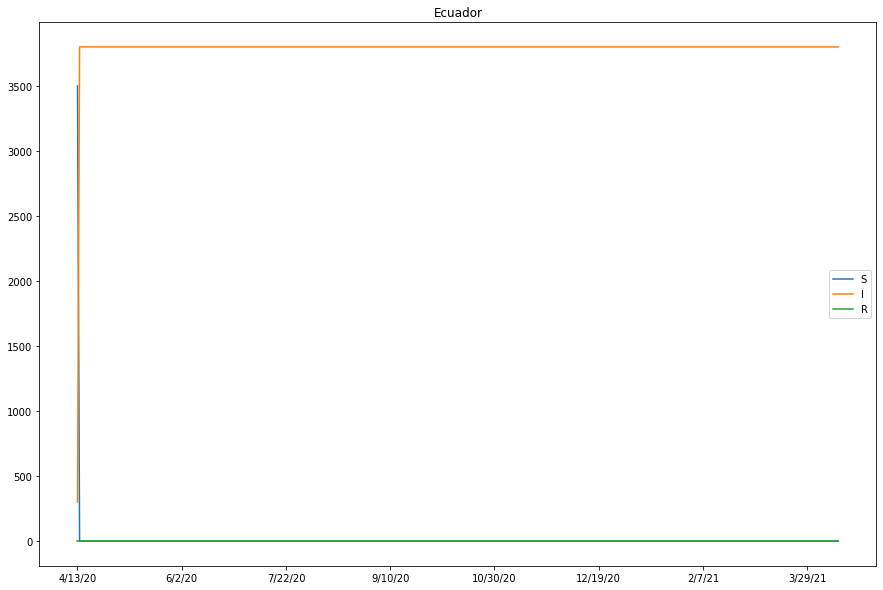

In [60]:
df = pd.DataFrame({
    'S': prediction.y[0],
    'I': prediction.y[1],
    'R': prediction.y[2]
}, index=new_index)
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Ecuador')
df.plot(ax=ax)

Al tratarse unicamente del analisis SIR para casos confirmados podemos ver que no existen recuperados, y por este motivo las personas infeccionas no reducen su cantidad en el transcurso del tiempo.

# Confirmados y Recuperados

In [61]:
dataConfirmed = data_confirmed
dataRecovered = data_recovered
optimal = minimize(
    loss_confirmed_recovered,
    [0.001, 0.001],
    args=(dataConfirmed, dataRecovered),
    method='L-BFGS-B',
    bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
)
betaC, gammaC = optimal.x

### Predicción

In [62]:
new_indexC, extended_actualC, predictionC = predict(betaC, gammaC, dataConfirmed)

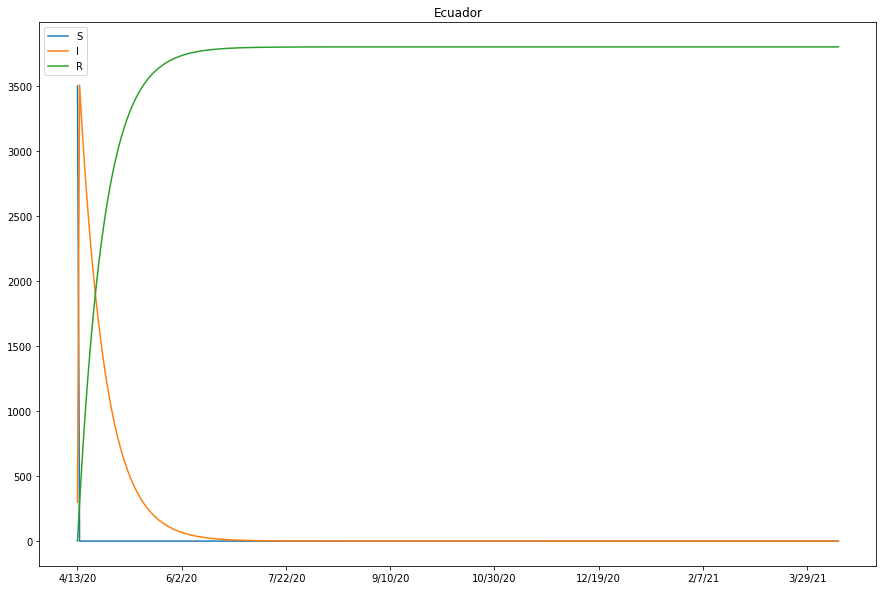

In [63]:
df = pd.DataFrame({
    'S': predictionC.y[0],
    'I': predictionC.y[1],
    'R': predictionC.y[2]
}, index=new_index)
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Ecuador')
df.plot(ax=ax)

En esta grafica a diferencia de la anterior nos podemos dar cuenta que los infecciosos disminuyen su valor mientras que los recuperados aumentan, sin embargo las personas suceptibles no sufren ningun cambio con respecto al anterior grafico